<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Using the Landlab NetworkSedimentTransporter component to initialize bed sediment

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

This tutorial illustrates how to initialize a stable bed to model the transport of coarse sediment through a river network using the NetworkSedimentTransporter Landlab component. For an equivalent tutorial demonstrating initialization of the NetworkSedimentTransporter with a *synthetic network model grid*, <a href="http://localhost:8888/notebooks/Documents/GitHub/landlab/notebooks/tutorials/network_sediment_transporter/network_sediment_transporter.ipynb">click here</a></small>.

In this example we will: 
- load a river network shapefile to create a Landlab grid to represent a river network
- estimate initial sediment size and "parcels"
- create sediment "parcels" that will transport through the river network, represented as items in a Landlab DataRecord
- run the component
- plot the results of the model run

Import the necessary libraries, plus a bit of magic so that we can plot within this notebook:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.constants
from landlab.components import FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.components.network_sediment_transporter import BedParcelInitializer
from landlab.data_record import DataRecord
from landlab.grid.network import NetworkModelGrid
from landlab.plot import graph
from landlab.io import read_shapefile
from landlab import ExampleData

from landlab.plot import plot_network_and_parcels
%matplotlib inline

## 1. Load a shapefile that represents the river network

First, we need to create a Landlab NetworkModelGrid to represent the river network. Each link on the grid represents a reach of river. Each node represents a break between reaches. All tributary junctions must be associated with grid nodes. 

In [2]:
datadir = ExampleData("io/shapefile", case="redb").base

shp_file =datadir/"a001_network.shp"
points_shapefile = datadir/"a001_nodes_att.shp"

grid = read_shapefile(
    shp_file,
    points_shapefile=points_shapefile,
    node_fields=["usarea_m2", "elev_m"],
    link_fields=["usarea_km2", "Length_m", "Slope"],
    link_field_conversion={"usarea_km2": "drainage_area", "Slope":"channel_slope", "Length_m":"reach_length"},
    node_field_conversion={
        "usarea_m2": "drainage_area_m2",
        "elev_m": "topographic__elevation",
    },
    threshold=0.01,
    )

Alright, let's see what fields we read in with this shapefile:

In [3]:
grid.at_link.keys()

['reach_length',
 'drainage_area',
 'channel_slope',
 'x_of_polyline',
 'y_of_polyline']

In [4]:
grid.at_node.keys()

['topographic__elevation', 'drainage_area_m2']

Great! Looks like we have length (reach length), upstream drainage area (drainage area), x and y verticies of each link/reach (x and y of polyline), and bed elevation (topographic elevation).

Note that "reach_length" is defined by the user, rather than calculated as the minimum distance between nodes. This accounts for channel sinuosity. In this case, "reach_length" could be equivalently calculated as the cumulative distance between verticies defined by x and y of polyline.

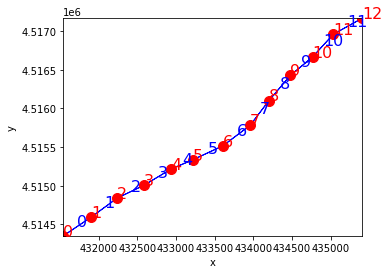

In [5]:
graph.plot_graph(grid, at="node,link")

Our network consists of 12 links (`grid.number_of_links`) between 13 nodes (`grid.number_of_nodes`). In the plot above, X and Y represent the plan-view coordinates of the node locations. 

Next, we need to populate the grid with the relevant topographic and hydrologic information: 

In [8]:
grid.at_node["bedrock__elevation"] = grid.at_node["topographic__elevation"].copy()

grid.at_link["channel_width"] = 1 * np.ones(grid.number_of_links) # m

grid.at_link["flow_depth"] = 0.5 * np.ones(grid.number_of_links) # m

We must distinguish between topographic elevation (the top surface of the bed sediment) and bedrock elevation (the surface of the river in the absence of modeled sediment).

## 2. Create initial sediment 'parcels' in a DataRecord

We represent sediment in the network as discrete parcels (or packages) of grains of uniform size and characteristics. Each parcel is tracked through the network grid according to sediment transport and stratigraphic constraints. 

Parcels are tracked using the Landlab <a href="http://localhost:8888/notebooks/Documents/GitHub/landlab/notebooks/tutorials/data_record/DataRecord_tutorial.ipynb">DataRecord</a>. 

#### METHOD 1: discharge
We calculate initial sediment grain size (d50) for each link using dominant discharge and channel width (via the Snyder et al.(2013) formula) and then d84 is calculated from standard deivation. Total parcel volume is function of active layer thickness, which is estimated from grain size (d84). We calculate the parcel volume by setting minimum number of parcels as 100. 
Let's create arrays with all of the essential sediment parcel variables by running the Landlab utility BedParcelInitializer: 

In [9]:
discharge_at_link = np.full(grid.number_of_links, 80.0)

initialize_parcels = BedParcelInitializer(grid,
                                           discharge_at_link = discharge_at_link
                                         )
parcels = initialize_parcels()

#### METHOD 2: depth
We calculate initial sediment grain size (d50) for each link using dominant flow depth. Other parcel attributes as above. 

In [10]:
depth= np.full(grid.number_of_links, 1.0)
initialize_parcels = BedParcelInitializer(grid,
                                          flow_depth_at_link = depth,
                                          )
parcels = initialize_parcels()

#### METHOD 3: drainage area
We calculate initial sediment grain size (d50) for each link using a power law scaling relationship with drainage area. Other parcel attributes as above. 

In [11]:
initialize_parcels = BedParcelInitializer(grid,
                                          drainage_area_coefficient = 0.1,
                                          drainage_area_exponent = 0.3
                                          )

parcels = initialize_parcels()

#### METHOD 4: user defined $D_{50}$
The user can specify either a d50 for each link in the network, or a single d50 for all links. 

In [12]:
d50_each_link= np.full(grid.number_of_links, 80.0)
# or
single_d50 = 0.05

initialize_parcels = BedParcelInitializer(grid,
                                          # user_d50 = d50_each_link,
                                          user_d50 = single_d50
                                          )

parcels = initialize_parcels()

d50 at each link.. [ 0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05]


#### Many options available for specifying $D_{50}$


In [14]:
date =  '2017-11-08 17:50:00'
starting_time = pd.to_datetime(date)

time = [starting_time]  

depth = np.full(grid.number_of_links, 1.2)
slope_depend_Shields = 0.15*grid.at_link['channel_slope']**0.25
tau_c_multiplier = 2.3 

initialize_parcels = BedParcelInitializer(grid,
                                          flow_depth_at_link = depth,
                                          tau_c_50=slope_depend_Shields,
                                          tau_c_multiplier = tau_c_multiplier,
                                          median_number_of_starting_parcels= 100,
                                          extra_parcel_attributes = ['lithology','Be10_c']
                                          )

parcels = initialize_parcels()

parcels.dataset['lithology'].values = np.full(parcels.number_of_items,'quartzite')
parcels.dataset['Be10_c'].values = np.full(parcels.number_of_items,'222.2')

In order to track sediment motion, we classify parcels as either active (representing mobile surface sediment) or inactive (immobile subsurface) during each timestep. The active parcels are the most recent parcels to arrive in the link. During a timestep, active parcels are transported downstream (increasing their `location_in_link`, which is a normalized value ranging from 0 to 1) according to a sediment transport formula. 

We begin by assigning each parcel an arbitrary (and small) arrival time and location in the link. 

In addition to the required parcel attributes listed above, you can designate optional parcel characteristics, depending on your needs. 
We now collect the arrays into a dictionary of variables, some of which will be tracked through time (`["item_id", "time"]`), and others of which will remain constant through time.
With all of the required attributes collected, we can create the parcels DataRecord. Often, parcels will eventually transport off of the downstream-most link. To track these parcels, we have designated a "`dummy_element`" here, which has index value `-2`. 

## 3. Run the NetworkSedimentTransporter

With the parcels and grid set up, we can move on to setting up the model. 

In [10]:
timesteps = 10 # total number of timesteps
dt = 60 * 60 * 24 *2 # length of timestep (seconds) 

Before running the NST, we need to determine flow direction on the grid (upstream and downstream for each link). To do so, we initalize and run a Landlab flow director component: 

In [13]:
fd = FlowDirectorSteepest(grid, "topographic__elevation")
fd.run_one_step()

Then, we initialize the network sediment transporter: 

In [14]:
nst = NetworkSedimentTransporter(    
    grid,
    parcels,
    fd,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
)

Now we are ready to run the model forward in time: 

In [15]:
for t in range(0, (timesteps * dt), dt):
    nst.run_one_step(dt)
    
    print("Model time: ", t/(60*60*24), "days passed")

Model time:  0.0 days passed
Model time:  2.0 days passed
Model time:  4.0 days passed
Model time:  6.0 days passed
Model time:  8.0 days passed
Model time:  10.0 days passed
Model time:  12.0 days passed
Model time:  14.0 days passed
Model time:  16.0 days passed
Model time:  18.0 days passed


## 4. Plot the model results

There are landlab plotting tools specific to the `NetworkSedimentTransporter`. In particular, `plot_network_and_parcels` creates a plan-view map of the network and parcels (represented as dots along the network). We can color both the parcels and the links by attributes.  

Here, we demonstrate one example use of `plot_network_and_parcels`. For a thorough tutorial on the plotting tools, see <a href="http://localhost:8888/notebooks/Documents/GitHub/landlab/notebooks/tutorials/network_sediment_transporter/network_plotting_examples.ipynb">this notebook</a>.


We can color links by values that we calculate. For example, if we are curious about the fate of sediment that started out on link 27, we might want to plot the total volume of sediment that originated on link 27 during a later timestep:

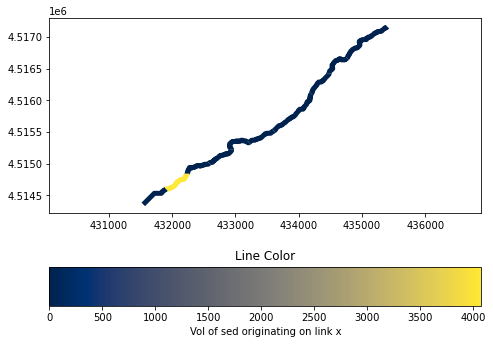

In [16]:
timestep_of_interest = 2
originating_link = 1

#filter the parcels to calculate total volumes of only the parcels that originated in the chosen link
parcelfilter = np.zeros_like(
    parcels.dataset.element_id, dtype=bool
)
parcelfilter[:, timestep_of_interest] = (parcels.dataset.element_id[:,0] == originating_link)

vol_orig_link = parcels.calc_aggregate_value(
            np.sum,
            "volume",
            at="link",
            filter_array=parcelfilter,
            fill_value=0.0
        )

fig = plot_network_and_parcels(
    grid, parcels,
    link_attribute=vol_orig_link, 
    link_attribute_title = "Vol of sed originating on link x",
    network_linewidth = 5,
    parcel_alpha = 0
)

#### Non-network plotting
The results of the NST can be visualized by directly accessing information about the grid, the parcels, and by accessing variables stored after the run of NST. 

As a simple example, we can plot the total volume of parcels on the grid through time. As parcels exit the grid, the total volume decreases.  

In [17]:
parcels.dataset

<xarray.Dataset>
Dimensions:               (item_id: 1131, time: 11)
Coordinates:
  * time                  (time) float64 0.0 1.728e+05 ... 1.555e+06 1.728e+06
  * item_id               (item_id) int32 0 1 2 3 4 ... 1126 1127 1128 1129 1130
Data variables:
    grid_element          (item_id, time) object 'link' 'link' ... 'link' 'link'
    element_id            (item_id, time) float64 0.0 0.0 0.0 ... 11.0 11.0 11.0
    starting_link         (item_id) int32 0 0 0 0 0 0 0 ... 11 11 11 11 11 11 11
    abrasion_rate         (item_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    density               (item_id) float64 2.65e+03 2.65e+03 ... 2.65e+03
    time_arrival_in_link  (item_id, time) float64 0.1872 0.1872 ... 0.4956
    active_layer          (item_id, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    location_in_link      (item_id, time) float64 0.3437 0.3437 ... 0.1168
    D                     (item_id, time) float64 1.149 1.149 ... 0.7296 0.7296
    volume                (item_id, time) float64 19.6 19.6 19.6 ... 39.66 39.66

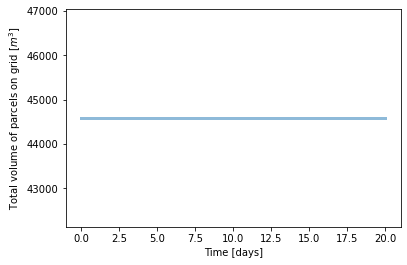

In [18]:
parcel_vol_on_grid = parcels.dataset["volume"].values
parcel_vol_on_grid[parcels.dataset["element_id"].values==-2]=0

#plt.figure(figsize=(8,6))
plt.plot(np.asarray(parcels.time_coordinates)/(60*60*24), 
         np.sum(parcel_vol_on_grid, axis=0),
         '-',
         linewidth=3, 
         alpha=0.5
        )

plt.ylabel('Total volume of parcels on grid $[m^3]$')
plt.xlabel('Time [days]')
plt.show() 

We can also plot individual parcel characteristics. The plot below shows the total transport distance of each parcel through the whole model run as a function of the parcel's grain size (during the final timestep). 

Text(0, 0.5, 'Cumulative parcel travel distance (m)')

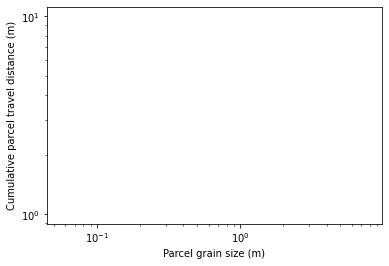

In [19]:
plt.loglog(parcels.dataset.D[:,-1],
         nst._distance_traveled_cumulative,
         '.'
        )
plt.xlabel('Parcel grain size (m)')
plt.ylabel('Cumulative parcel travel distance (m)')

# Note: some of the smallest grain travel distances can exceed the length of the 
# grid by "overshooting" during a single timestep of high transport rate


The plot below is an example of accessing variables associated with the grid (`grid.at_link.X`, or `grid.at_node.X`), as well as a variable associated with this instance of NetworkModelGrid (`nmg.X`):

In [20]:
nst.d_mean_active

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan])

Text(0, 0.5, 'Mean grain size of active layer (m)')

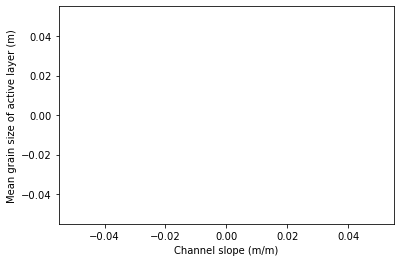

In [21]:
plt.plot(grid.at_link["channel_slope"],
         nst.d_mean_active, 
         '.')
plt.xlabel('Channel slope (m/m)')
plt.ylabel('Mean grain size of active layer (m)')